## Imports

In [1]:
using CSV
using DataFrames
using SciPyDiffEq
using Plots
using OrdinaryDiffEq

### Importando arquivos em dataframes

In [2]:
dados = DataFrame(CSV.File("../dados_usados/Dados_novos_BAHIA.csv"))
casos_dados = dados[!,"Casos acumulados"]
mortos_dados = dados[!, "Mortos"]
vacinados = dados[!, "Vacinados"]
datas = dados[!, "datetime"]

334-element Vector{Dates.Date}:
 2021-01-01
 2021-01-02
 2021-01-03
 2021-01-04
 2021-01-05
 2021-01-06
 2021-01-07
 2021-01-08
 2021-01-09
 2021-01-10
 ⋮
 2021-11-22
 2021-11-23
 2021-11-24
 2021-11-25
 2021-11-26
 2021-11-27
 2021-11-28
 2021-11-29
 2021-11-30

## Limpando taxas de vacinação negativas

In [3]:
vacinados_dados_aux =  copy(vacinados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(2, length(vacinados_dados_aux))
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]

    if diff < 0
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]
    end
end
novos_vacinados =  diff(vacinados_dados_aux)

333-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Parametros

In [4]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

# Parametros da vacina    
delta_av = 0.31
delta_sv = 0.31
phi_e = 0.7
k_v=1/3
p_v = 0.1
gamma_av = 1/3.5
gamma_sv = 1/4
gamma_vu=0.26
qsi_v = 0.99
eps=0.7 # eficacia da vacina
mi_vh=0.03
mi_vu=0.08
gamma_vh=0.36

0.36

## Modelo

In [5]:
function SEIIHURD(du, y,p2,t)
    #beta0, beta1, beta2,beta3, t1, t2, t3, vacina_metade = args

    if t< 126.48480189
        beta= 1.90221545    
    elseif (t>= 126.48480189)
        beta=3.76585085
    elseif (t>=172.97799643)
        beta=2.14629225
    elseif t>=288.57269974
        beta=3.27760444
    end
    #if vacina_metade == "COMPLETO"
    #    eps = 1
    #elseif vacina_metade == "METADE"
     #   eps = 0.35
    #else
    eps = 0.7
   # end

    beta_v = beta/2
    tau = novos_vacinados[floor(Int, t)+1]
    N=14873064
    psi= 0.5  #Psif[int(t)]

    S=y[1]
    E=y[2]
    V=y[3]
    Sv=y[4]
    Ev=y[5]
    Ia=y[6]
    Is=y[7]
    Iav=y[8]
    Isv=y[9]
    H=y[10]
    Hv=y[11]
    U=y[12]
    Uv=y[13]
    R=y[14]
    Rv=y[15]
    D=y[16]
    Nw=y[17]
    NwV=y[18]

    du[1] = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    du[2] = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    du[3] = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    du[4] =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    du[5] = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    du[6] = (1-p)*k*E - gamma_a*Ia
    du[7] = p*k*E - gamma_s*Is
    du[8] = (1-p_v)*k_v*Ev - gamma_av*Iav
    du[9] = p_v*k_v*Ev - gamma_sv*Isv   
    du[10] = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    du[11] = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    du[12] = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    du[13] = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    du[14] = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    du[15] = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    du[16] = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    du[17] = p*k*E + p_v*k_v*Ev
    du[18] = tau/N

    #return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
           # dRvdt, dDdt, dNwdt, dNwVdt]
end

SEIIHURD (generic function with 1 method)

## Condicoes iniciais

In [6]:
condicoes_iniciais = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0.0,
    0.0,
    0.0,
    0.0015491725384642486,
    0.0004385474858925033,
    0.0,
    0.0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0.0,
    9159/14873064,
    494684/14873064,
    0.0
]

18-element Vector{Float64}:
 0.8002151436282163
 0.0023662791892471815
 0.0
 0.0
 0.0
 0.0015491725384642486
 0.0004385474858925033
 0.0
 0.0
 3.0058880370174367e-5
 0.0
 2.5542546092586197e-5
 0.0
 0.15650499264821266
 0.0
 0.0006158112410462296
 0.03326039610936926
 0.0

## Integração numérica

In [7]:
tspan = (0.0, 332.0)
p2 = [0]
prob = ODEProblem(SEIIHURD, condicoes_iniciais, tspan, p2)
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 365-element Vector{Float64}:
   0.0
   0.2609159461492035
   1.276920889300955
   2.8084707193549354
   4.705149680177054
   7.273319637501225
  10.561430674425768
  14.988301628333613
  17.63741295270626
  18.385697709053346
   ⋮
 321.6424250273697
 322.8328701152184
 323.7723493882987
 324.76338237462437
 325.67394428438473
 327.3159073418079
 328.7320826963295
 330.67197253958244
 332.0
u: 365-element Vector{Vector{Float64}}:
 [0.8002151436282163, 0.0023662791892471815, 0.0, 0.0, 0.0, 0.0015491725384642486, 0.0004385474858925033, 0.0, 0.0, 3.0058880370174367e-5, 0.0, 2.5542546092586197e-5, 0.0, 0.15650499264821266, 0.0, 0.0006158112410462296, 0.03326039610936926, 0.0]
 [0.8000322238509314, 0.0023939420986435304, 0.0, 0.0, 0.0, 0.0015575828164213607, 0.00044091670194933114, 0.0, 0.0, 3.0178468043495042e-5, 0.0, 2.5680693131907313e-5, 0.0, 0.15664878309889121, 0.0, 0.0006162404295297164, 0.03329144748294698,

## Mortos

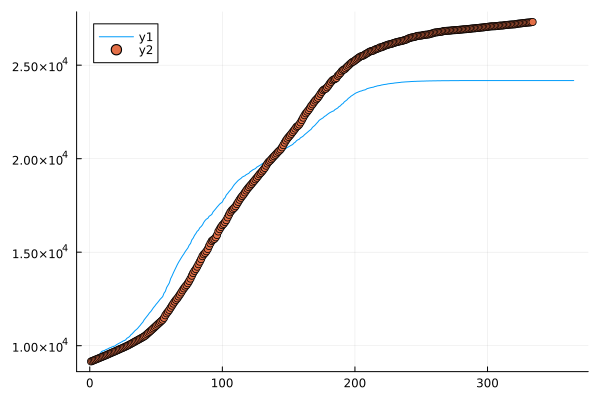

In [8]:
mortos = []
for item in sol.u
    morto =  (item[16]*14873064)
    push!(mortos,morto)
end
plot(mortos)
plot!(mortos_dados, seriestype=:scatter)

## Casos

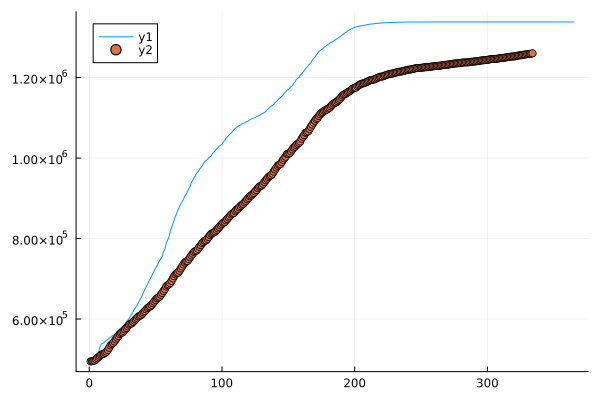

In [9]:
casos = []
for item in sol.u
    caso =  (item[17]*14873064)
    push!(casos, caso)
end
plot(casos)
plot!(casos_dados, seriestype=:scatter)